In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
from machine_learning.process_data import process_data, read_fasta  # 导入处理数据的函数
import joblib

warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 定义路径
path = Path('/')

In [2]:
def prepare_features(df):
    """
    准备特征和标签（标签已经是'0'和'1'字符串）
    """
    # 分离特征和标签
    X = df.drop(['Sequence', 'toxicity'], axis=1)
    y = df['toxicity']

    # 将字符串'0'/'1'转换为整数
    y_numeric = y.astype(int)

    return X, y_numeric

In [3]:
def train_random_forest_with_cv(X_train, y_train):
    # 特征标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 简单的参数网格（可根据需要扩展）
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    # 网格搜索（内部使用5折交叉验证）
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        param_grid,
        cv=5,
        scoring='f1',          # 以F1分数为优化目标
        n_jobs=-1
    )

    print("🔍 正在进行超参数调优（网格搜索）...")
    grid_search.fit(X_train_scaled, y_train)

    print(f"\n✅ 最佳参数: {grid_search.best_params_}")
    print(f"最佳交叉验证F1分数: {grid_search.best_score_:.4f}")

    model = grid_search.best_estimator_

    return model, scaler

In [4]:
def evaluate_model(model, X_test, y_test):
    """
    评估模型在测试集上的性能
    """

    # 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # 二分类用binary
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"精确率 (Precision): {precision:.4f}")
    print(f"召回率 (Recall): {recall:.4f}")
    print(f"F1分数 (F1-score): {f1:.4f}")

    # 详细分类报告
    print("\n详细分类报告:")
    print(classification_report(y_test, y_pred, target_names=['无毒(0)', '有毒(1)']))

    return y_pred, y_pred_proba

In [5]:
def plot_confusion_matrix(y_test, y_pred, save_path):
    """
    绘制并保存混淆矩阵
    """
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['无毒(0)', '有毒(1)'],
                yticklabels=['无毒(0)', '有毒(1)'])
    plt.title('混淆矩阵 - 测试集')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [6]:
def plot_feature_importance(model, feature_names, save_path, top_n=20):
    """
    绘制并保存特征重要性图
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # 取前top_n个特征
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [feature_names[i] for i in top_indices]

    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), top_importances[::-1])
    plt.yticks(range(top_n), top_names[::-1])
    plt.xlabel('重要性')
    plt.title(f'前{top_n}个最重要的特征')
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"特征重要性图已保存至: {save_path}")

In [7]:
def save_predictions(model, X_test, y_test, y_pred, save_path):
    """
    保存详细的预测结果
    """
    y_pred_proba = model.predict_proba(X_test)

    results = pd.DataFrame({
        '真实标签': y_test,
        '预测标签': y_pred,
        '预测正确': y_test == y_pred,
        '无毒概率': y_pred_proba[:, 0],
        '有毒概率': y_pred_proba[:, 1]
    })

    # 添加预测结果解释
    results['真实类别'] = results['真实标签'].map({0: '无毒', 1: '有毒'})
    results['预测类别'] = results['预测标签'].map({0: '无毒', 1: '有毒'})

    results.to_csv(save_path, index=False)
    print(f"详细预测结果已保存至: {save_path}")

    # 显示错误分类的样本
    errors = results[results['预测正确'] == False]
    if len(errors) > 0:
        print(f"\n错误分类的样本数: {len(errors)} ({len(errors)/len(y_test)*100:.1f}%)")
        print("\n错误分类示例:")
        print(errors[['真实类别', '预测类别', '无毒概率', '有毒概率']].head())

In [8]:
# 创建结果目录
results_dir = path / 'results1'
results_dir.mkdir(exist_ok=True)

In [9]:
# 1. 加载并处理训练数据
train_file = path / 'data/train_data.fasta'
train_data = read_fasta(train_file)
processed_train = process_data(train_data)


处理完成！
样本数: 6387
特征数: 132
样本/特征比: 48.4:1


In [10]:
# 2. 准备训练特征和标签
X_train = processed_train.drop(['Sequence', 'toxicity'], axis=1)
y_train = processed_train['toxicity'].astype(int)  # 字符串'0'/'1'转整数
# 显示训练集标签分布
print(f"  特征维度: {X_train.shape[1]}")
print(f"  训练集标签分布:")
print(f"    无毒 (0): {(y_train == 0).sum()} 样本 ({((y_train == 0).sum() / len(y_train) * 100):.1f}%)")
print(f"    有毒 (1): {(y_train == 1).sum()} 样本 ({((y_train == 1).sum() / len(y_train) * 100):.1f}%)")


  特征维度: 132
  训练集标签分布:
    无毒 (0): 4569 样本 (71.5%)
    有毒 (1): 1818 样本 (28.5%)


In [11]:
# 3. 训练模型
rf_model, scaler = train_random_forest_with_cv(X_train, y_train)

🔍 正在进行超参数调优（网格搜索）...

✅ 最佳参数: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
最佳交叉验证F1分数: 0.8486


In [12]:
# 4. 加载并处理测试数据
test_file1 = path / 'data/test1.fasta'
test_data1 = read_fasta(test_file1)
test_file2 = path / 'data/test2.fasta'
test_data2 = read_fasta(test_file2)
test_data = pd.concat([test_data1, test_data2], ignore_index=True)
processed_test = process_data(test_data)
print(f"测试集样本数: {len(processed_test)}")


处理完成！
样本数: 1708
特征数: 132
样本/特征比: 12.9:1
测试集样本数: 1708


In [13]:
# 5. 准备测试特征和标签
X_test = processed_test.drop(['Sequence', 'toxicity'], axis=1)
y_test = processed_test['toxicity'].astype(int)
# 确保测试集的特征列与训练集一致
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X_train.columns]  # 保持列顺序一致
# 标准化测试数据
X_test_scaled = scaler.transform(X_test)

In [14]:
# 6. 在测试集上进行预测
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

In [15]:
#  7. 模型评估结果
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# 计算预测正确率
correct_predictions = (y_test == y_pred).sum()
total_predictions = len(y_test)
correct_rate = correct_predictions / total_predictions

print(f"  预测正确数: {correct_predictions}/{total_predictions}")
print(f"  预测正确率: {correct_rate:.4f} ({correct_rate * 100:.2f}%)")
print(f"  预测错误数: {total_predictions - correct_predictions}/{total_predictions}")
print(f"  预测错误率: {1 - correct_rate:.4f} ({(1 - correct_rate) * 100:.2f}%)")
print("-" * 40)
print(f"  准确率 (Accuracy):  {accuracy:.4f}")
print(f"  精确率 (Precision): {precision:.4f}")
print(f"  召回率 (Recall):    {recall:.4f}")
print(f"  F1分数 (F1-score):  {f1:.4f}")

  预测正确数: 1567/1708
  预测正确率: 0.9174 (91.74%)
  预测错误数: 141/1708
  预测错误率: 0.0826 (8.26%)
----------------------------------------
  准确率 (Accuracy):  0.9174
  精确率 (Precision): 0.8378
  召回率 (Recall):    0.7623
  F1分数 (F1-score):  0.7983


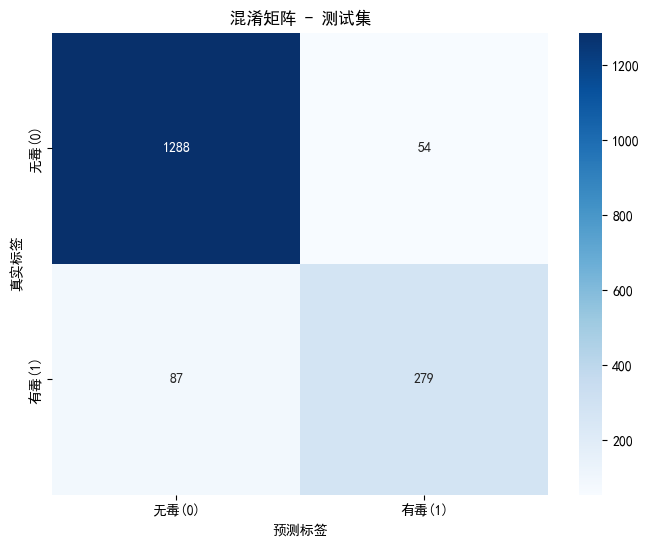

<Figure size 640x480 with 0 Axes>

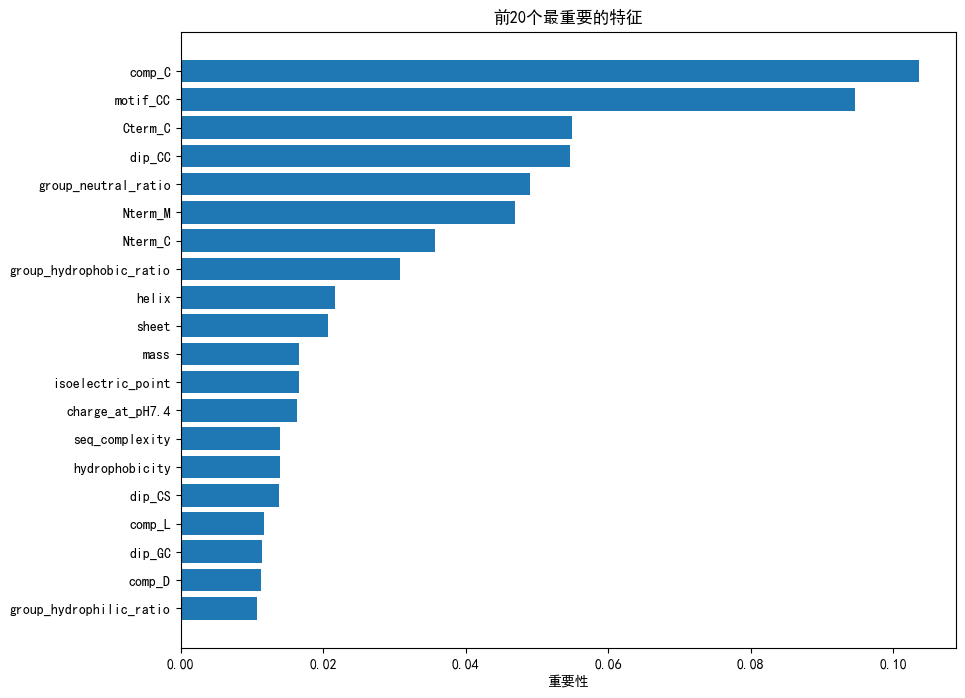

特征重要性图已保存至: D:\Python\dachuang2026\results1\feature_importance.png


<Figure size 640x480 with 0 Axes>

In [17]:
#  8. 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, results_dir / 'confusion_matrix.png')
plot_feature_importance(rf_model, X_train.columns, results_dir / 'feature_importance.png')

In [18]:
# 9. 保存详细预测结果
save_predictions(rf_model, X_test_scaled, y_test, y_pred, results_dir / 'detailed_predictions.csv')

详细预测结果已保存至: D:\Python\dachuang2026\results1\detailed_predictions.csv

错误分类的样本数: 141 (8.3%)

错误分类示例:
   真实类别 预测类别  无毒概率  有毒概率
0    有毒   无毒  0.76  0.24
1    有毒   无毒  0.95  0.05
11   有毒   无毒  0.66  0.34
13   有毒   无毒  0.67  0.33
14   有毒   无毒  0.59  0.41


In [19]:
# 10. 保存模型和相关文件
joblib.dump(rf_model, results_dir / 'random_forest_model.joblib')
joblib.dump(scaler, results_dir / 'scaler.pkl')

['D:\\Python\\dachuang2026\\results1\\scaler.pkl']

In [20]:
# 11. 结果汇总
print(f"\n📊 结果汇总:")
print(f"  - 训练集大小: {len(X_train)} 个样本")
print(f"  - 测试集大小: {len(X_test)} 个样本")
print(f"  - 特征数量: {X_train.shape[1]}")
print(f"  - 准确率: {accuracy:.4f}")
print(f"  - F1分数: {f1:.4f}")
print(f"\n📁 结果保存位置: {results_dir}")


📊 结果汇总:
  - 训练集大小: 6387 个样本
  - 测试集大小: 1708 个样本
  - 特征数量: 132
  - 准确率: 0.9174
  - F1分数: 0.7983

📁 结果保存位置: D:\Python\dachuang2026\results1
